In [1]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import os
import math
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
N = 1000 # number of paths to load from path dataset
L = 1000 # fixed length for sin wave training data
T = 20

# dataset name
MAP_NAME = '8x12_map_cropped'
DATASET = 'random_paths'
MAP_SHAPE = (64,64)

# training parameters
BATCH_SIZE = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

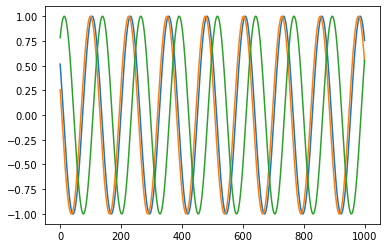

In [3]:
x = np.empty((N, L), np.float32)
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N,1) # want to shift all vlaues of each instance of training data a bit
y = np.sin(x/1.0/T).astype(np.float32) # create corresponding sine values

plt.figure()
plt.plot(y[0])
plt.plot(y[342])
plt.plot(y[832]) # they all are shifted withing +/- 20 of each other

In [4]:
class PathsDataset(torch.utils.data.Dataset):
    # init the dataset, shape = L x W
    def __init__(self, path_dir, map_file, transform=None, shape = (100,100), device='cpu'):
        self.device = device
        self.paths = [] # create a list to hold all paths read from file
        # self.map = np.loadtxt(map_file, skiprows=2).reshape(shape)
        # self.map = self.map[np.newaxis, :, :]
        for filename in tqdm(os.listdir(path_dir)):
            with open(os.path.join(path_dir, filename), 'r') as f: # open in readonly mode
                self.flat_path = np.loadtxt(f) # load in the flat path from file
                self.path = np.asarray(self.flat_path, dtype=int).reshape(len(self.flat_path)//2,2) #unflatten the path from the file

                self.path_matrix = self.convert_path(shape, self.path)
                
                self.paths.append(self.path_matrix) # add the path to paths list
        self.transform = transform
        print("Done!")

    def convert_path(self, map_dim, path):
        path_mat = np.zeros(map_dim, dtype=float)

        # Make the path continuous
        for i in range(path.shape[0] - 1):
            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            if (x1 < x2):
                x_dir = 1
            else:
                x_dir = -1

            if (y1 < y2):
                y_dir = 1
            else:
                y_dir = -1

            # Determine y from x
            if x2-x1 != 0:
                m = (y2-y1)/(x2-x1)
                while x != x2:
                    y = round(m*(x-x1) + y1)
                    path_mat[y,x] = 1
                    x += x_dir
            else:
                while x != x2:
                    path_mat[y1,x] = 1
                    x += x_dir


            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            # Determine x from y
            if y2-y1 != 0:
                m = (x2-x1)/(y2-y1)
                while y != y2:
                    x = round(m*(y-y1) + x1)
                    path_mat[y,x] = 1
                    y += y_dir
            else:
                while y != y2:
                    path_mat[y,x1] = 1
                    y += y_dir

        # print(path)
            
        # path_mat[path[path.shape[0]-1,1], path[path.shape[0]-1,0]] = 1     # Include the last point in the path

        


        # Add Initial Path onto the loaded path matrix
        initial_path = np.zeros_like(path_mat)

        # # Create Straight line between start/end points
        # x1 = path[0,0]
        # y1 = path[0,1]
        # x2 = path[path.shape[0]-1,0]
        # y2 = path[path.shape[0]-1,1]

        # x = x1
        # y = y1

        # if (x1 < x2):
        #     x_dir = 1
        # else:
        #     x_dir = -1

        # if (y1 < y2):
        #     y_dir = 1
        # else:
        #     y_dir = -1

        # # Determine y from x
        # if x2-x1 != 0:
        #     m = (y2-y1)/(x2-x1)
        #     while x != x2:
        #         y = round(m*(x-x1) + y1)
        #         initial_path[y,x] = 1
        #         x += x_dir
        # else:
        #     while x != x2:
        #         initial_path[y1,x] = 1
        #         x += x_dir

        # x = x1
        # y = y1
        # # Determine x from y
        # if y2-y1 != 0:
        #     m = (x2-x1)/(y2-y1)
        #     while y != y2:
        #         x = round(m*(y-y1) + x1)
        #         initial_path[y,x] = 1
        #         y += y_dir
        # else:
        #     while y != y2:
        #         initial_path[y,x1] = 1
        #         y += y_dir

        # initial_path[y1,x1] = 1     # Include the first point in the path
        # initial_path[y2,x2] = 1     # Include the last point in the path

        # gradient code
        # slope = -0.025

        # for x in range(0, len(initial_path)):
        #     for y in range(0, len(initial_path[x])):
        #         dis_start = math.sqrt((x-x1)**2 + (y-y1)**2)
        #         dis_goal = math.sqrt((x-x2)**2 + (y-y2)**2)
        #         dis = dis_start if dis_start < dis_goal else dis_goal

        #         height = slope*dis + 1

        #         if height < 0:
        #             initial_path[y][x] = 0
        #         else:
        #             initial_path[y][x] = height

        # path_mat = np.stack((path_mat, initial_path))

        return path_mat

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        x = np.float32(self.paths[idx])
        x = torch.Tensor(x).to(self.device)

        if self.transform:
            x = self.transform(x)
        
        return x

        #return image, label

In [5]:
train_dataset = PathsDataset(path_dir = f"./env/{MAP_NAME}/paths/{DATASET}/small_2000", map_file = f"./env/{MAP_NAME}/{MAP_NAME}.txt", shape = MAP_SHAPE, transform=None, device=device)
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

100%|██████████| 1991/1991 [00:00<00:00, 3242.34it/s]

Done!


cuda
1991
torch.Size([64, 64])


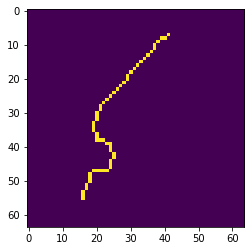

In [6]:
print(train_dataset.device)
print(len(train_dataset))
print(train_dataset[23].shape)
plt.imshow(train_dataset[23].cpu().detach().numpy())

In [7]:
from turtle import forward


class LSTMPredictor(torch.nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        # lstm1, lstm2, linear
        self.lstm1 = nn.LSTMCell(1, self.n_hidden) # input size 1 since we go thorugh one by one
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1) # only predict one value on output layer

    def forward(self, x, future=0): # future prediction optionally allows for prediction of future values
        outputs = []
        n_samples = x.size(0)

        h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32) # initial hidden state layer 1
        c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32) # initial cell state layer 1
        h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32) # initial hidden state lastm layer 2
        c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32) # initial hidden state lastm layer 2

        for input_t in x.split(1, dim=1):   # allows us to look at one element at a time for each item in batch
                                            # split the tensor into chunks, where each chunk is a view of the data
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)

        for i  in range(future): # if we are trying to predict future values (if future is not zero)
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)

        # concat outputs and put into tensor
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [8]:
if __name__ == "__main__":
    # for training + testing we only want to look at the "y values", we don't care about "time step"
    train_input = torch.from_numpy(y[3:, :-1]) # start at sample #3, and take values from beginning until last value (Excluded)
    train_target = torch.from_numpy(y[3:, 1:]) # starts at 1 and goes to end, so we can compare the input to the output which has the value at +1 index further

    test_input = torch.from_numpy(y[:3, :-1]) # start at sample #3, and take values from beginning until last value (Excluded)
    test_target = torch.from_numpy(y[:3, 1:]) # starts at 1 and goes to end, so we can compare the input to the output which has the value at +1 index further

In [15]:
model = LSTMPredictor()
loss_func = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(), lr = 0.9)

n_steps = 10

# training loop
for i in range (n_steps):
    print(f'step: {i}')


    def closure():
        optimizer.zero_grad()
        out = model(train_input)
        loss = loss_func(out, train_target)
        print(f'loss: {loss.item()}')
        loss.backward()
        return loss
    optimizer.step(closure)

step: 0
loss: 0.5280944108963013
loss: 0.5140265822410583
loss: 0.4858493208885193
loss: 0.4759712815284729
loss: 0.41358911991119385
loss: 2.628089666366577
loss: 0.2887710630893707
loss: 0.20174983143806458
loss: 1240.2696533203125
loss: 4.734197616577148
loss: 0.1966882348060608
loss: 0.020824166014790535
loss: 0.020540092140436172
loss: 0.0199880450963974
loss: 0.01927625760436058
loss: 0.017605522647500038
loss: 0.014092841185629368
loss: 0.007791082840412855
loss: 0.003522635903209448
loss: 0.002678876742720604
step: 1
loss: 0.002483928808942437
loss: 0.0023773442953824997
loss: 0.002163076074793935
loss: 0.0017522716661915183
loss: 0.0013496237806975842
loss: 0.0011799640487879515
loss: 0.0011404190445318818
loss: 0.0011188535718247294
loss: 0.001078314962796867
loss: 0.0010183207923546433
loss: 0.0008957758545875549
loss: 0.0007219247636385262
loss: 0.0006009584758430719
loss: 0.0005707613890990615
loss: 0.00048393593169748783
loss: 0.00039057142566889524
loss: 0.00033973008976

In [18]:
# prediction loop
with torch.no_grad():
    future=1000
    pred = model(test_input, future=future)
    loss = loss_func(pred[:, :-future], test_target)
    print(f'loss: {loss.item()}')
    y = pred.detach().numpy()

loss: 7.729589924565516e-06


(3, 1999)


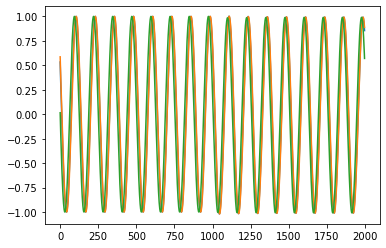

In [19]:
print(y.shape)
plt.figure()
plt.plot(y[0])
plt.plot(y[1])
plt.plot(y[2])
plt.show()